<a href="https://colab.research.google.com/github/DavideGioiosa/master-thesis-polimi/blob/master/CVAE_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional Variational Autoencoder

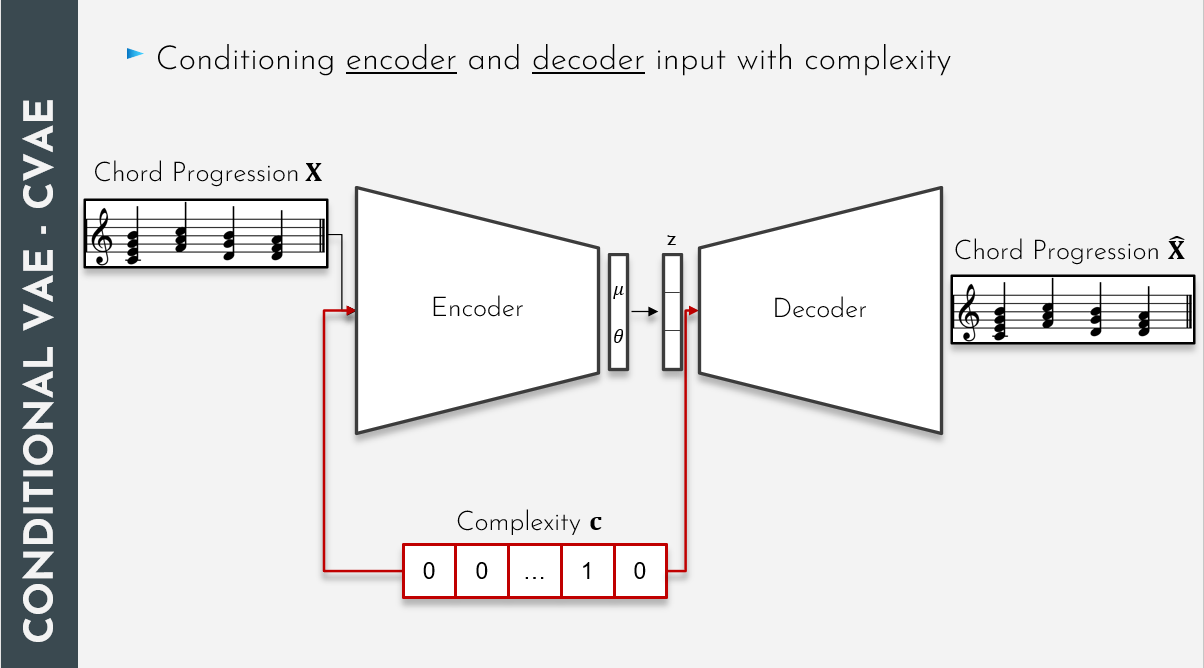

Clone the github repo

In [1]:
! git clone https://github.com/DavideGioiosa/master-thesis-polimi.git

Cloning into 'master-thesis-polimi'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 199 (delta 92), reused 92 (delta 29), pack-reused 0
Receiving objects: 100% (199/199), 4.28 MiB | 8.37 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [2]:
import os
os.chdir('/content/master-thesis-polimi')
os.getcwd()

'/content/master-thesis-polimi'

In [3]:
! pip install -r requirements.txt

     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 320.4 MB 44 kB/s 
     |████████████████████████████████| 11.2 MB 50.8 MB/s 
     |████████████████████████████████| 1.0 MB 35.6 MB/s 
     |████████████████████████████████| 2.9 MB 31.3 MB/s 
     |████████████████████████████████| 459 kB 68.7 MB/s 
     |████████████████████████████████| 895 kB 55.2 MB/s 
  Created wheel for MIDIUtil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54566 sha256=4ba7edadd8f1537b7d68add55e1f87ac82d8961834585f9876f8d39b56ace370
  Stored in directory: /root/.cache/pip/wheels/e3/97/cd/a677b61a76d575f373e2e10302f1d9106507fea6dd1320df03
Successfully built MIDIUtil
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
   

**Note: Go to 'Runtime' -> 'Restart Runtime'**

The runtime must be restarted for google colab to use the version indicated in the requirements.txt for TensorFlow.

Then start running the code from here.

In [1]:
import os
os.chdir('/content/master-thesis-polimi')
os.getcwd()

import pandas as pd
from utils import constants, dataframe_utils
from utils.symbolic_format_converter import get_chords_sequence_symbolic_from_piano_roll
from Models.CVAE import ConditionalVAE
from Generators.generator_cvae import GeneratorCVAE
from tensorflow.keras.utils import to_categorical

from utils.midi_synthesis import symbolic_2_midi
from utils import wav_synthesis
from IPython.display import Audio

In [5]:
# The complexity classes have been reduced from 30 to 5
# constants.REDUCED_COMPLEXITY_CLASSES

# LOAD DATA: 1 octave - 5x12 matrix
df = pd.read_csv('PR_Chord_Sequences_w_Harmonic_Complexity.csv')

# Cast of 30 complexity classes to 5
df = dataframe_utils.decrease_num_of_bins(df, constants.REDUCED_COMPLEXITY_BINS)

print("N. of chord sequences per each of the " + str(constants.REDUCED_COMPLEXITY_BINS) + " complexity classes")
print(df.groupby('Bin').size())

print("N. of the MAJOR chord sequences per each of the " + str(
    constants.REDUCED_COMPLEXITY_BINS) + " complexity classes")
print(df[df["Type"] == 'maj'].groupby('Bin').size())

print("N. of the MINOR chord sequences per each of the " + str(
    constants.REDUCED_COMPLEXITY_BINS) + " complexity classes")
print(df[df["Type"] == 'min'].groupby('Bin').size())

df_sequences = dataframe_utils.get_chords_sequences_from_csv(df)
print("Example of chord sequence: ")
print(df_sequences[0])

N. of chord sequences per each of the 5 complexity classes
Bin
0     205
1    1446
2    2582
3    1877
4     201
dtype: int64
N. of the MAJOR chord sequences per each of the 5 complexity classes
Bin
0      64
1     709
2    1314
3    1020
4     133
dtype: int64
N. of the MINOR chord sequences per each of the 5 complexity classes
Bin
0     141
1     737
2    1268
3     857
4      68
dtype: int64
Example of chord sequence: 
[[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]]


In [6]:
train_size = 0.7
val_size = 0.1
test_size = 0.2
print("Split train " + str(train_size) + "% validation " + str(val_size) + "% test " + str(test_size) + "%")
train_data_PR, valid_data_PR, test_data_PR = dataframe_utils.split_train_test_validation(df)

train_data_sequences = dataframe_utils.get_chords_sequences_from_csv(train_data_PR)
valid_data_sequences = dataframe_utils.get_chords_sequences_from_csv(valid_data_PR)
test_data_sequences = dataframe_utils.get_chords_sequences_from_csv(test_data_PR)

# Set input flat
train_data_sequences_flat = train_data_sequences.reshape((len(train_data_sequences), -1))
valid_data_sequences_flat = valid_data_sequences.reshape((len(valid_data_sequences), -1))
test_data_sequences_flat = test_data_sequences.reshape((len(test_data_sequences), -1))

print("Example of chord sequence: ")
print(get_chords_sequence_symbolic_from_piano_roll(train_data_sequences[0]))
print("In Multi-hot vector format, Matrix 5x12: ")
print(train_data_sequences[0])


# One hot encoding
one_h_complexity_train = to_categorical(train_data_PR['Bin'])
one_h_complexity_valid = to_categorical(valid_data_PR['Bin'])
one_h_complexity_test = to_categorical(test_data_PR['Bin'])

print("Example of one hot encoding of harmonic complexity bin:")
print(one_h_complexity_train[0])

Split train 0.7% validation 0.1% test 0.2%
Example of chord sequence: 
['Cmaj', 'Dmin', 'Amin', 'G#min', 'Cmaj']
In Multi-hot vector format, Matrix 5x12: 
[[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]]
Example of one hot encoding of harmonic complexity bin:
[0. 0. 1. 0. 0.]


In [7]:
# CVAE model
conditional_vae = ConditionalVAE()
conditional_vae.train(train_data_sequences_flat, one_h_complexity_train, 
                      valid_data_sequences_flat, one_h_complexity_valid)

Epoch 1/250
142/142 [==============================] - 2s 14ms/step - loss: 23.9726 - val_loss: 21.6952
Epoch 2/250
142/142 [==============================] - 2s 13ms/step - loss: 21.3567 - val_loss: 21.1884
Epoch 3/250
142/142 [==============================] - 2s 12ms/step - loss: 21.0296 - val_loss: 21.1318
Epoch 4/250
142/142 [==============================] - 2s 12ms/step - loss: 20.8434 - val_loss: 20.9466
Epoch 5/250
142/142 [==============================] - 2s 12ms/step - loss: 20.6960 - val_loss: 20.6897
Epoch 6/250
142/142 [==============================] - 2s 12ms/step - loss: 20.5387 - val_loss: 20.4855
Epoch 7/250
142/142 [==============================] - 2s 12ms/step - loss: 20.3278 - val_loss: 20.4095
Epoch 8/250
142/142 [==============================] - 2s 12ms/step - loss: 20.1195 - val_loss: 20.1273
Epoch 9/250
142/142 [==============================] - 2s 12ms/step - loss: 19.9730 - val_loss: 20.1046
Epoch 10/250
142/142 [==============================] - 2s 12ms/

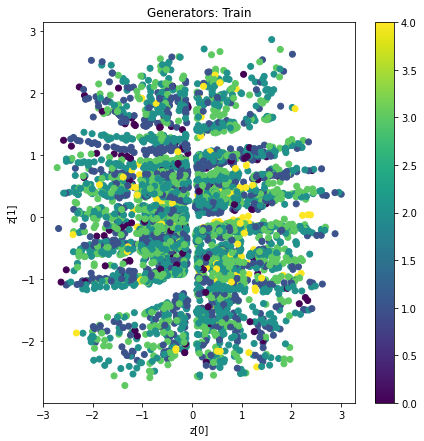

In [8]:
conditional_vae.plots(train_data_sequences_flat, one_h_complexity_train, train_data_PR['Bin'], "Train")

## Examples of generation from latent space


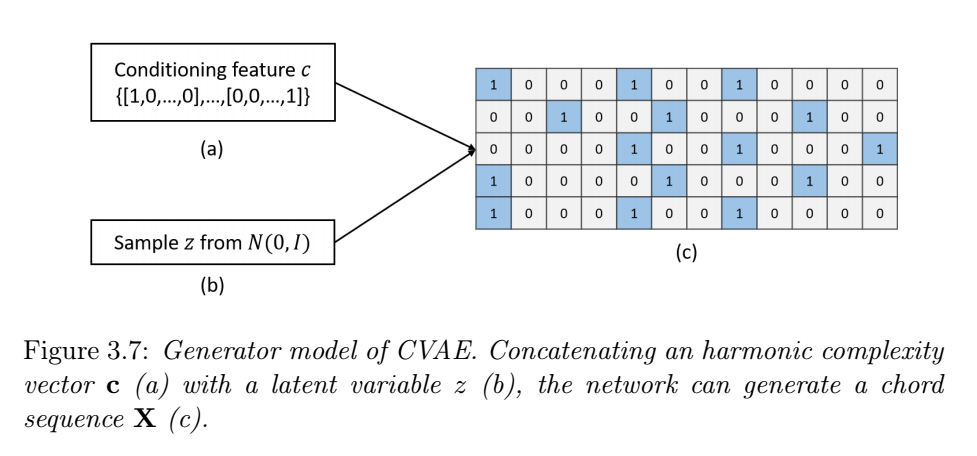

In [9]:
# Generation of chord sequences

generator_cvae = GeneratorCVAE(conditional_vae.decoder)

# 1st Method: indicating the complexity bin [0-4]
print("Complexity 0 - lowest")
print(get_chords_sequence_symbolic_from_piano_roll(generator_cvae.generate_with_complexity(0)))
print(get_chords_sequence_symbolic_from_piano_roll(generator_cvae.generate_with_complexity(0)))

print("\n")

print("Complexity 4 - highest")
print(get_chords_sequence_symbolic_from_piano_roll(generator_cvae.generate_with_complexity(4)))
print(get_chords_sequence_symbolic_from_piano_roll(generator_cvae.generate_with_complexity(4)))

Complexity 0 - lowest

Z_:  [-0.7859, 0.9097]
['Cmin', 'Fmin', 'Cmin', 'A#maj', 'Cmin']

Z_:  [1.8518, 1.0365]
['Cmaj', 'Fmaj', 'G5', 'Fmaj', 'Cmaj']


Complexity 4 - highest

Z_:  [-0.3151, -0.4365]
['Cmin', 'F#7', 'B7', 'D#7', 'Cmin']

Z_:  [-0.3433, -0.2604]
['Cmin', 'C#min', 'B7', 'D#7', 'Cmin']


In [10]:
# 2nd Method: indicating the complexity bin [0-4] and the coordinates z_x, z_y

print(get_chords_sequence_symbolic_from_piano_roll(
    generator_cvae.generate_with_complexity_and_z_coord(0, -1, 1)))

print(get_chords_sequence_symbolic_from_piano_roll(
    generator_cvae.generate_with_complexity_and_z_coord(0, -1., -1)))


Z_:  [-1, 1]
['Cmin', 'Fmin', 'Cmin', 'Fmin', 'Cmin']

Z_:  [-1.0, -1]
['Cmin', 'D#maj', 'Cmin', 'Fmin', 'Cmin']


## Generation of chords sequence

**Generation in Symbolic domain -> Conversion into Midi format -> Conversion in wav format**

In [11]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ub

Generates a sequence of chords with the indicated complexity value, transforms it into midi and then into wav using FluidSynth

In [14]:
# *********
# Harmonic complexity bin to set for the chords sequence generation
# *********
harmonic_complexity_bin = 4

# method 1
generated_seq = generator_cvae.generate_with_complexity(harmonic_complexity_bin)

"""
# method 2
z_x = -1.2
z_y = 0.5
generated_seq = generator_cvae.generate_with_complexity_and_z_coord(harmonic_complexity_bin, z_x, z_y)
"""

print("Generated sequence:")
print(get_chords_sequence_symbolic_from_piano_roll(generated_seq))
print("\n") 

# convert to MIDI
path = 'Generated_outputs/'
filename = "generated_CVAE_" + str(harmonic_complexity_bin)
midi_name = filename + ".mid"
symbolic_2_midi(generated_seq, filename)

# convert to .wav
wav_synthesis.midi_2_wav(path + midi_name, path + filename + '.wav')
Audio(path + filename + '.wav')


Z_:  [-2.441, -0.2347]
Generated sequence:
['Cmin', 'Emaj', 'A7', 'G#maj', 'Cmin']


generating voicings for  C D# G  ...2781 voicings found
generating voicings for  E G# B  ...1406 voicings found
generating voicings for  C# E G A  ...9211 voicings found
generating voicings for  C D# G#  ...3786 voicings found
generating voicings for  C D# G  ...2781 voicings found
computing observations.....
computing transitions....
Midi Created
FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'Generated_outputs/generated_CVAE_4.wav'..




*Example 2*

In [18]:
# *********
# Harmonic complexity bin to set for the chords sequence generation
# *********
harmonic_complexity_bin = 0

# method 1
generated_seq = generator_cvae.generate_with_complexity(harmonic_complexity_bin)

print("Generated sequence:")
print(get_chords_sequence_symbolic_from_piano_roll(generated_seq))
print("\n") 

# convert to MIDI
path = 'Generated_outputs/'
filename = "generated_CVAE_" + str(harmonic_complexity_bin)
midi_name = filename + ".mid"
symbolic_2_midi(generated_seq, filename)

# convert to .wav
wav_synthesis.midi_2_wav(path + midi_name, path + filename + '.wav')
Audio(path + filename + '.wav')


Z_:  [2.4698, -0.9657]
Generated sequence:
['Cmaj', 'Gmaj', 'Dmin', 'Fmaj', 'Cmaj']


generating voicings for  C E G  ...2001 voicings found
generating voicings for  D G B  ...1406 voicings found
generating voicings for  D F A  ...2001 voicings found
generating voicings for  C F A  ...1406 voicings found
generating voicings for  C E G  ...2001 voicings found
computing observations.....
computing transitions....
Midi Created
FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'Generated_outputs/generated_CVAE_0.wav'..


